# AE4 Recommender Challenge EDSA
#### Unsupervised_learning_AE4_DSFT21
<div style="width:100%;text-align: center;"> <img align=middle src="https://github.com/Jean-LucVanZyl/unsupervised-predict-streamlit-template/blob/fca0aedd189023bfd5537732290b66e3df797de2/Images/0f22ad161f0a604907d6447f6c88da78.png?raw=true'" alt="Heat beating" style="height:500px;margin-top:3rem;"> </div>

## Table of Contents

1. <a href ="#1.-Challenge-Description">Challenge Description</a>
2. <a href ="#2.-Evaluation-Metric">Evaluation Metric</a>
3. <a href ="#3.-Comet-Experiment">Comet Experiment</a>
3. <a href ="#4.-Importing-Libraries">Importing Libraries</a>
4. <a href ="#5.-Importing-Data">Importing Data</a>
5. <a href ="#6.-Dimensionality-Reduction">Dimensionality Reduction</a>
6. <a href ="#6.-Model-Building">Model Building</a>
7. <a href ="#7.-Conclusion">Conclusion</a>




## 1. Challenge Description

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

With this context, EDSA is challenging US to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

## 2. Evaluation Metric

The evaluation metric for this competition is Root Mean Square Error. Root Mean Square Error  is commonly used in regression analysis and forecasting, and measures the standard deviation of the residuals arising between predicted and actual observed values for a modelling process. For our task of generating user movie ratings via recommendation algorithms, the the formula is given by:

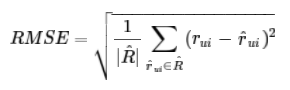
Where \\( \hat{R} \\) is the total number of recommendations generated for users and movies, with \\( r_{ui} \\) and \\( \hat{r}_{ui} \\) being the true and predicted ratings for user \\( u \\) watching movie \\( i \\) respectively.

## 3. Comet Experiment 

In [1]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="1AwUmDPCaKw7TZWLKwrSQ2n9z",
    project_name="general",
    workspace="jean-lucvanzyl",
)



COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/jean-lucvanzyl/general/afe6acd83d3a4d48864e739db376e3e2



## 4. Importing Libraries
In this notebook we shall be importing various python libraries to assist with constructing our classification model.

In [12]:
import numpy as np
import pandas as pd
import cufflinks as cf
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


## 5. Importing Data

In [3]:
#Movies dataframe
movies_df = pd.read_csv('movies.csv')

#Genome_scores dataframe
gs_df = pd.read_csv('genome_scores.csv')

#Genome_tags dataframe
gt_df = pd.read_csv('genome_tags.csv')

#imbd dataframe
imdb_df = pd.read_csv('imdb_data.csv')

#links dataframe
links_df = pd.read_csv('links.csv')

#tags dataframe
tags_df = pd.read_csv('tags.csv')

#train dataframe
train_df = pd.read_csv('train.csv')

#test dataframe 
test_df = pd.read_csv('test.csv')


We need to determine the rating score for the respective movieId and submit a csv file in that format for the Kaggle competition. Lets take a look at the features and shape of our training data.

In [4]:
train_df.head()


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [5]:
train_df.shape

(10000038, 4)

Looking at the shape of the dataframe, we find we have 4 columns and more than 10 million observations, which is going to require a fair bit of processing power to work through. The column names are User ID, Movie ID, Rating and Timestamp. All of the data to train our model upon has numerical data types, perfect for unsupervised learning. The columns aren't measured on the same scale, so lets scale the data first and afterwards apply dimensionality reduction.

## 5. Scales of measurement

Scaling data is vitally important because not all variables are measured on the same scales and/or using the same units. We can clearly see that the mean of the Rating column would be substantially lower than the mean of the Movie ID column.

Let's take a look at box plots of the variables to better understand this measurement discrepancy. 

In [14]:
features = [col for col in train_df.columns]

In [ ]:
# create scaler object
scaler = StandardScaler()

# define scaled data frame variable
train_df_scaled = pd.read_csv('train.csv')
train_df_scaled[features] = preprocessing.scale(train_df_scaled[features])

# plot boxplots using scaled data
train_df_scaled[features].iplot(kind='box', title="Boxplots of Features (Scaled)")

C:\Users\JeanLucVanZyl\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning:

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.



In [7]:
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')

# using plotly to plot the boxplot
train_df[features].iplot(kind='box', title="Boxplots of Features (Unscaled)")


## 6. Dimensionality Reduction

The problems with increasing or high levels of dimensionality of our dataframes are as follows:

- More storage space required for the data;
- More computation time required to work with the data; and
- More features mean more chance of feature correlation, and hence feature redundancy.

For the reasons above, lets apply Principle Component Analysis (PCA).

## Principal Component Analysis
The premise of PCA is that data in some higher number of dimensions can be mapped to some lower number of dimensions, whilst retaining the maximum amount of variance in the lower dimension. Lets apply the following steps;
1. Perform feature scaling on our data; 
2. Construct the covariance matrix of the data;
3. Compute the eigenvectors of this matrix; and Eigenvectors corresponding to the largest eigenvalues are used to reconstruct a maximal fraction of variance of the original data.

In [8]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/jean-lucvanzyl/general/afe6acd83d3a4d48864e739db376e3e2
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (10 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...
